## Process downloaded GPP

In this notebook, previously prepared 8-Day GPP data from MODIS and VODCA2 is further processed to retrieve monthly and spatially aggregated mean values. The following steps are included:
- Use VODCA2 and MODIS GPP data that has been quality filtered and cropped to NL / BL forest area
- Convert MODIS data from 8-day aggregations to daily values and from kgC to gC
- Calculate monthly mean values of daily GPP for each pixel in gC/m²/day
- Spatially aggregate GPP for each federal state to retrieve mean value per state and month

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


### Calculate Monthly MODIS GPP

In [3]:
# the 8-day MODIS GPP data consists of 8-day accumulations of GPP
# we want to work with means, not accumulations (like VODCA2GPP)
# therefore, we have to convert the 8-day accumulations to daily data
# according to the documentation (https://lpdaac.usgs.gov/documents/972/MOD17_User_Guide_V61.pdf): 
# "To obtain an estimate of daily GPP for this 8- day period, it is necessary to divide the value obtained during a data download 
# by eight for the first 45 values/year and by five (or six in a leap year) for the final period"

In [4]:
# define a function to convert the 8-day accumulations to daily values

def to_daily_gpp(gpp_ds, time_dim = "time"):
    
    # get year values
    time = gpp_ds[time_dim]
    gpp_year = pd.to_datetime(time.values[0]).year
    
    # make sure the dataset really has 46 values
    if len(time) != 46:
        raise ValueError(f"Expected 46 time steps for one year, but found {len(time)}")
    
    # check if there are 5 or 6 days in the final period
    leap_year = pd.Timestamp(f"{gpp_year}-12-31").is_leap_year
    last_divisor = 6 if leap_year else 5

    # build array of divisors - 8 for the first 45 values, 5 or 6 for the last one
    divisors = [8] * 45 + [last_divisor]
    divisors_da = xr.DataArray(divisors, coords = {time_dim: time}, dims = time_dim)

    # return dataset with daily gpp values
    return gpp_ds / divisors_da

In [5]:
# create list with forest types
forest_types = ("NL", "BL")

In [6]:
# process GPP from MODIS data

for year in range(2000, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./GPP/GPP_MODIS/8Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        gpp = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # convert 8-day accumulations to daily values
        gpp_daily = to_daily_gpp(gpp)

        # convert from kgC to gC for better comparison to other products
        gpp_daily['GPP'] = gpp_daily['GPP'] * 1000

        # calculate monthly mean values
        gpp_mon_mean = gpp_daily.resample(time="1MS", skipna=True).mean("time")

        # set unit in variable attributes
        gpp_mon_mean.GPP.attrs["units"] = "monthly mean of gC/m²/day"

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        gpp_mon_mean.GPP.encoding.update(comp)

        # save created datasets as netCDF4 files
        gpp_mon_mean.to_netcdf(f"./GPP/GPP_MODIS/Monthly/GPP_mon_mean_{year}_{forest_type}.nc")

In [7]:
# look at exemplary datasets to get an overview
gpp_mon_mean

<xarray.Dataset> Size: 995MB
Dimensions:      (time: 12, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
Data variables:
    GPP          (time, lat, lon) float64 995MB dask.array<chunksize=(1, 1476, 1755), meta=np.ndarray>

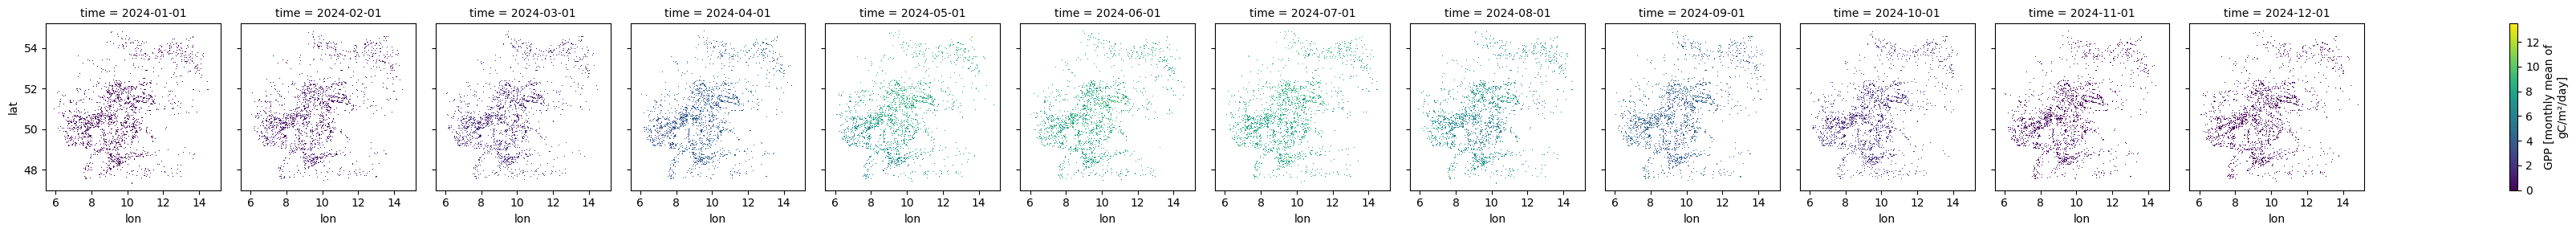

In [8]:
gpp_mon_mean.GPP.sel(time = slice('2024-01', '2024-12')).plot(col="time")

### Spatially aggregate monthly MODIS GPP

In [9]:
# spatially aggregate monthly GPP data
# to get mean values for Germany and federal states

In [10]:
# first, get values for broadleaved forest
# load all monthly gpp values as one dataset
directory = f"./GPP/GPP_MODIS/Monthly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
gpp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [11]:
# calculate mean gpp values per month for Germany
gpp_monthly_spatial_means = gpp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
gpp_monthly_spatial_means

,GPP,crs,spatial_ref
time,,,
2000-01-01,0.150231,-127,0
2000-02-01,0.480098,-127,0
2000-03-01,1.134153,-127,0
2000-04-01,4.493022,-127,0
2000-05-01,7.337403,-127,0
...,...,...,...
2024-08-01,6.482536,-127,0
2024-09-01,4.049793,-127,0
2024-10-01,1.796794,-127,0


In [12]:
# drop unneeded columns
gpp_monthly_spatial_means = gpp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [13]:
# rename column with gpp value to show area
gpp_monthly_spatial_means.rename({"GPP":"GER"}, axis=1, inplace=True)

In [14]:
# now, calculate monthly mean gpp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    gpp_ex = gpp_monthly.sel(time = "2000-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=gpp_ex.odc.geobox.shape,
                                                transform=gpp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    gpp_state = gpp_monthly["GPP"].where(~state_mask)

    # calculate monthly mean gpp of state and extract to dataframe
    gpp_state_spatial_means = gpp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    gpp_state_spatial_means = gpp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean gpp values of state to dataframe
    gpp_monthly_spatial_means[state] = gpp_state_spatial_means["GPP"]   

In [15]:
gpp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
2000-01-01,0.150231,0.129445,0.117408,0.139752,0.110825,0.182102,0.150588,0.159059,0.149596,0.178117,0.179243,0.179733,0.163147,0.157990,0.105073,0.153417,0.123808
2000-02-01,0.480098,0.437481,0.419968,0.543348,0.451945,0.523509,0.466732,0.479845,0.441183,0.488579,0.503142,0.510089,0.484191,0.484030,0.361283,0.440541,0.395555
2000-03-01,1.134153,0.906308,0.882080,1.192127,1.107535,1.203409,1.205981,1.066556,0.999767,1.144135,1.238918,1.174112,1.090856,1.058068,0.953562,1.001668,0.997046
2000-04-01,4.493022,4.753977,4.430456,4.310899,4.336738,4.568537,4.487037,4.365009,4.924544,4.548315,4.515996,4.519964,4.608554,4.413538,4.615247,4.581425,4.499309
2000-05-01,7.337403,6.929364,6.620692,7.714488,7.687305,7.656439,7.227059,7.228577,7.549060,7.063496,6.886016,7.230887,7.656040,7.293799,6.905669,6.956592,7.229316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,6.482536,5.960690,5.337568,6.334730,5.967248,6.647917,6.220296,6.613473,6.852409,6.848925,6.804538,6.717467,6.870218,7.361299,5.642819,6.478206,6.641884
2024-09-01,4.049793,3.719794,3.572078,3.919673,3.930030,4.162007,4.028237,4.268064,4.124195,4.154247,4.258886,4.214772,4.357337,4.380727,3.477491,3.812162,4.003197
2024-10-01,1.796794,1.907267,1.967010,1.939810,1.823869,1.651864,1.688023,1.641502,1.755552,1.765486,1.769037,1.756397,1.623937,1.995688,1.930002,1.884002,1.756881


In [16]:
# save as csv dataset
gpp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/GPP_MODIS_Monthly_Spatial_Means_BL.csv")

In [17]:
# now follow the same steps for needleleaved forest
# load all monthly gpp values as one dataset
directory = f"./GPP/GPP_MODIS/Monthly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
gpp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [18]:
# calculate mean gpp values per month for Germany
gpp_monthly_spatial_means = gpp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
gpp_monthly_spatial_means

,GPP,crs,spatial_ref
time,,,
2000-01-01,0.180393,-127,0
2000-02-01,0.630249,-127,0
2000-03-01,1.414844,-127,0
2000-04-01,4.552391,-127,0
2000-05-01,6.539746,-127,0
...,...,...,...
2024-08-01,5.808935,-127,0
2024-09-01,3.818331,-127,0
2024-10-01,2.035602,-127,0


In [19]:
# drop unneeded columns
gpp_monthly_spatial_means = gpp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [20]:
# rename column with gpp value to show area
gpp_monthly_spatial_means.rename({"GPP":"GER"}, axis=1, inplace=True)

In [21]:
# now, calculate monthly mean gpp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    gpp_ex = gpp_monthly.sel(time = "2000-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=gpp_ex.odc.geobox.shape,
                                                transform=gpp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    gpp_state = gpp_monthly["GPP"].where(~state_mask)

    # calculate monthly mean gpp of state and extract to dataframe
    gpp_state_spatial_means = gpp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    gpp_state_spatial_means = gpp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean gpp values of state to dataframe
    gpp_monthly_spatial_means[state] = gpp_state_spatial_means["GPP"]   

In [22]:
gpp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
2000-01-01,0.180393,0.234657,0.173967,0.175239,0.108076,0.206447,0.181355,0.186653,0.212244,0.249198,0.191398,0.225049,0.199499,0.189166,0.131180,0.258532,0.134642
2000-02-01,0.630249,0.746268,0.605542,0.662183,0.545933,0.550789,0.598286,0.583940,0.665160,0.701576,0.576036,0.652767,0.605566,0.569666,0.506242,0.751352,0.546283
2000-03-01,1.414844,1.448190,1.226291,1.539607,1.328196,1.136809,1.461143,1.243212,1.324212,1.535224,1.440803,1.452322,1.320094,1.243394,1.226464,1.553531,1.375918
2000-04-01,4.552391,4.808382,4.412108,4.481797,4.343648,4.172599,4.578006,4.146574,4.824667,4.525118,4.314634,4.574133,4.555395,4.382638,4.715644,4.702652,4.567609
2000-05-01,6.539746,5.823182,5.727852,7.021550,6.941378,6.492325,6.946620,6.452669,6.472457,6.387005,6.419605,6.862074,6.965874,6.933207,6.454958,5.989251,6.817757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,5.808935,5.246402,4.770223,6.005891,5.670790,5.986842,5.757965,6.267537,6.482621,6.426174,6.598493,6.389403,6.643107,6.957410,5.193765,5.978738,5.511827
2024-09-01,3.818331,3.520210,3.451271,3.840234,3.822138,3.892681,3.938516,4.094201,4.007775,4.157289,4.213319,4.208053,4.381296,4.147242,3.595350,3.629261,3.603898
2024-10-01,2.035602,2.199630,2.138736,2.316863,2.023655,1.674383,1.852658,1.629843,1.904948,1.857102,1.730656,1.929651,1.717649,2.019101,2.188915,2.035262,1.913373


In [23]:
# save as csv dataset
gpp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/GPP_MODIS_Monthly_Spatial_Means_NL.csv")

### Calculate Monthly VODCA2 GPP

In [24]:
# the 8-day VODCA2 GPP data consists of 8-day means of daily GPP
# so we do not have to convert those to daily values like we did with MODIS GPP

In [25]:
# create list with forest types
forest_types = ("NL", "BL")

In [26]:
# process GPP from MODIS data

for year in range(1988, 2021):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./GPP/GPP_VODCA2/8Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        gpp = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        gpp_mon_mean = gpp.resample(time="1MS", skipna=True).mean("time")

        # set unit in variable attributes
        gpp_mon_mean.GPP.attrs["units"] = "monthly mean of gC/m²/day"

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        gpp_mon_mean.GPP.encoding.update(comp)

        # save created datasets as netCDF4 files
        gpp_mon_mean.to_netcdf(f"./GPP/GPP_VODCA2/Monthly/GPP_mon_mean_{year}_{forest_type}.nc")

In [28]:
# look at exemplary datasets to get an overview
gpp_mon_mean = xr.open_dataarray("./GPP/GPP_VODCA2/Monthly/GPP_mon_mean_2019_BL.nc", decode_coords = "all", decode_times= True)
gpp_mon_mean

<xarray.DataArray 'GPP' (time: 12, lat: 2952, lon: 3510)> Size: 995MB
[124338240 values with dtype=float64]
Coordinates:
    crs          |S1 1B ...
    spatial_ref  int64 8B ...
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 96B 2019-01-01 2019-02-01 ... 2019-12-01
Attributes:
    units:      monthly mean of gC/m²/day
    long_name:  VODCA-based GPP estimate

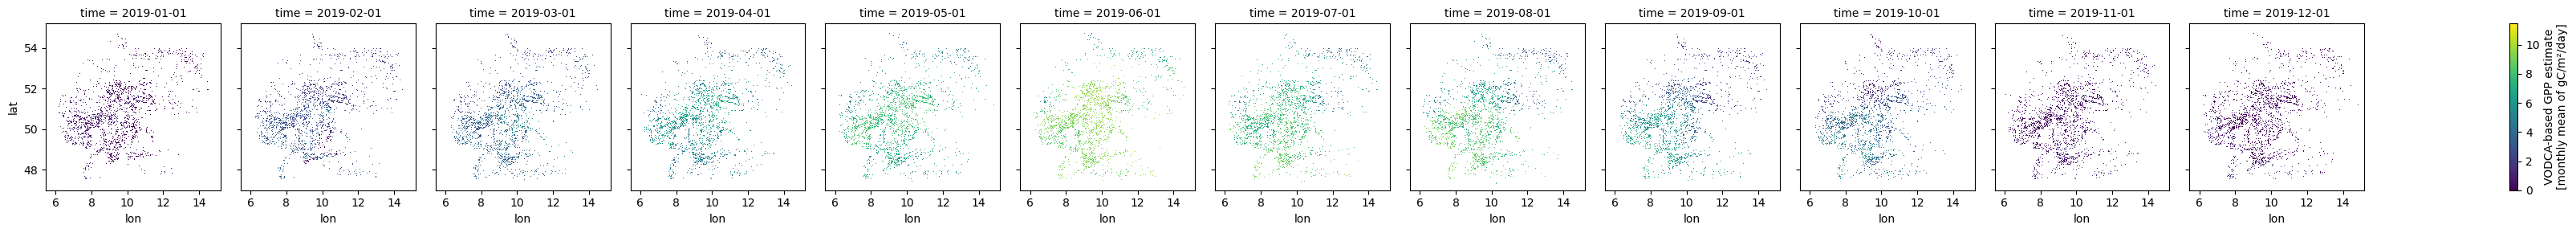

In [30]:
gpp_mon_mean.sel(time = slice('2019-01', '2019-12')).plot(col="time")

### Spatially aggregate monthly VODCA2 GPP

In [31]:
# spatially aggregate monthly GPP data
# to get mean values for Germany and federal states

In [32]:
# first, get values for broadleaved forest
# load all monthly gpp values as one dataset
directory = f"./GPP/GPP_VODCA2/Monthly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
gpp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [33]:
# calculate mean gpp values per month for Germany
gpp_monthly_spatial_means = gpp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
gpp_monthly_spatial_means

,GPP,crs,spatial_ref
time,,,
1988-02-01,0.593664,b'',0
1988-03-01,1.679584,b'',0
1988-04-01,4.614831,b'',0
1988-05-01,8.291438,b'',0
1988-06-01,8.409732,b'',0
...,...,...,...
2020-02-01,1.058604,b'',0
2020-03-01,3.666223,b'',0
2020-04-01,6.749686,b'',0


In [34]:
# drop unneeded columns
gpp_monthly_spatial_means = gpp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [35]:
# rename column with gpp value to show area
gpp_monthly_spatial_means.rename({"GPP":"GER"}, axis=1, inplace=True)

In [36]:
# now, calculate monthly mean gpp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    gpp_ex = gpp_monthly.sel(time = "1988-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=gpp_ex.odc.geobox.shape,
                                                transform=gpp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    gpp_state = gpp_monthly["GPP"].where(~state_mask)

    # calculate monthly mean gpp of state and extract to dataframe
    gpp_state_spatial_means = gpp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    gpp_state_spatial_means = gpp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean gpp values of state to dataframe
    gpp_monthly_spatial_means[state] = gpp_state_spatial_means["GPP"]   

c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs

In [37]:
gpp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1988-02-01,0.593664,0.266313,0.619393,0.806294,1.025672,0.000000,0.515695,0.346977,0.580923,0.520176,0.234785,0.416751,0.373041,0.573416,0.714130,0.562362,0.700085
1988-03-01,1.679584,1.276672,1.056835,1.495320,1.278836,1.834091,1.728658,1.082142,0.996541,1.788188,1.564881,2.317743,1.294190,2.704566,1.450744,1.587249,1.906022
1988-04-01,4.614831,5.129172,3.588465,4.846880,3.570466,5.040919,4.684849,3.950902,3.316051,3.892250,4.734156,6.378637,3.911209,7.331479,4.362554,3.995971,3.309407
1988-05-01,8.291438,6.691965,5.673320,8.142059,8.889325,7.173940,8.801732,5.839154,5.334996,8.713481,7.827675,8.496286,5.625776,8.224978,7.731661,8.458310,9.084813
1988-06-01,8.409732,7.471415,6.709205,8.577601,8.737694,7.874648,8.594866,6.901163,6.247360,8.662486,7.900676,8.664605,6.671780,8.676384,8.257880,8.646308,8.726389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1.058604,0.856078,1.000382,1.200516,1.013022,0.261768,1.127878,0.458232,0.619235,0.613234,0.884283,1.492433,0.311421,1.583252,1.186589,1.050048,1.086755
2020-03-01,3.666223,3.284865,2.382407,3.712973,2.946423,2.961350,4.254535,3.684796,2.580242,2.478591,3.175272,5.006457,2.848541,4.991056,4.107812,4.051747,3.638241
2020-04-01,6.749686,4.396600,4.142806,7.017262,6.912202,4.707565,7.482797,4.115115,3.538796,6.451359,6.169588,7.718469,3.458913,8.078348,6.231911,6.336331,7.287789


In [38]:
# save as csv dataset
gpp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/GPP_VODCA2_Monthly_Spatial_Means_BL.csv")

In [39]:
# now follow the same steps for needleleaved forest
# load all monthly gpp values as one dataset
directory = f"./GPP/GPP_VODCA2/Monthly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
gpp_monthly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [40]:
# calculate mean gpp values per month for Germany
gpp_monthly_spatial_means = gpp_monthly.mean(['lon','lat'], skipna=True).to_dataframe()
gpp_monthly_spatial_means

,GPP,crs,spatial_ref
time,,,
1988-02-01,0.649970,b'',0
1988-03-01,1.591527,b'',0
1988-04-01,4.570860,b'',0
1988-05-01,8.064410,b'',0
1988-06-01,8.305957,b'',0
...,...,...,...
2020-02-01,1.049468,b'',0
2020-03-01,3.802725,b'',0
2020-04-01,6.184208,b'',0


In [41]:
# drop unneeded columns
gpp_monthly_spatial_means = gpp_monthly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [42]:
# rename column with gpp value to show area
gpp_monthly_spatial_means.rename({"GPP":"GER"}, axis=1, inplace=True)

In [43]:
# now, calculate monthly mean gpp values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    gpp_ex = gpp_monthly.sel(time = "1988-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=gpp_ex.odc.geobox.shape,
                                                transform=gpp_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask data
    gpp_state = gpp_monthly["GPP"].where(~state_mask)

    # calculate monthly mean gpp of state and extract to dataframe
    gpp_state_spatial_means = gpp_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    gpp_state_spatial_means = gpp_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add monthly mean gpp values of state to dataframe
    gpp_monthly_spatial_means[state] = gpp_state_spatial_means["GPP"]   

c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs\Thesis_Msc\Lib\site-packages\odc\geo\_xr_interop.py:632: UserWarning: Multiple CRS coordinates are present
  warnings.warn("Multiple CRS coordinates are present")
c:\Users\irish\miniconda3\envs

In [44]:
gpp_monthly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1988-02-01,0.649970,0.230217,0.700936,1.438922,1.040796,0.046526,0.626646,0.257976,0.553740,0.390129,0.548340,0.477307,0.372508,0.592669,0.731533,0.374886,0.722916
1988-03-01,1.591527,1.538053,1.066433,2.041689,1.271462,1.798982,1.797862,1.146621,1.038096,1.629877,2.309033,2.319758,1.289885,2.676274,1.697008,1.450281,1.350107
1988-04-01,4.570860,5.491940,3.608726,5.718213,3.347433,5.082856,4.759167,4.083937,3.632616,4.706868,5.734787,6.444413,3.776310,7.399302,4.220336,4.681592,3.642452
1988-05-01,8.064410,7.058273,5.756697,8.189963,8.565150,6.855628,8.674553,5.896436,5.952687,8.357268,8.136533,8.356556,5.696417,8.154158,8.048795,8.353664,9.216715
1988-06-01,8.305957,7.743391,6.702579,8.364026,8.683364,7.592536,8.543371,6.911900,6.654295,8.637151,8.107834,8.533428,6.803078,8.647031,8.361120,8.549472,8.789573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,1.049468,0.905625,1.011553,1.617886,1.160241,0.247228,1.129776,0.494052,0.600372,0.526669,1.062306,1.514934,0.245846,1.660184,1.145109,0.928855,1.313153
2020-03-01,3.802725,3.591992,2.341666,4.410730,3.990568,3.111439,4.069636,3.700656,2.811225,2.892108,3.994703,4.963567,3.114850,4.750822,3.771290,3.848136,4.431684
2020-04-01,6.184208,4.806482,4.212041,7.335952,6.588616,4.515455,7.630537,4.163099,3.790193,5.853629,6.935151,7.475865,3.611993,7.860965,6.239616,6.072026,7.268787


In [45]:
# save as csv dataset
gpp_monthly_spatial_means.to_csv("./Tables/Spatial_Means/GPP_VODCA2_Monthly_Spatial_Means_NL.csv")